Now that we've gotten familiar some with linear and convolutional learning models, let's be introduced to another model called the Generative Adversarial Network, or GAN for short. GAN models gained great interest when they appeared a few years in part due to their performance, but also due to their intriguing method of learning. What is unique about GANs is that they employ a game-like model, similar perhaps to game theory, where one part of the network tries to outperform the other part of the network. In doing so, they make each other stronger, for when one part of the network loses, it learns. And when it outperforms the other part of the network, the other part learns too.

The 2 parts of the network we are referring to are the **generator** and the **discriminator**. Suppose we have an image of a painting. Simply put, the generator tries to produce a "fake" sample of the painting, while the discriminator must classify each sample it receives as a true or fake sample. If the discriminator correctly labels the generator's sample as false, loss is applied to the generator model. If the discriminator incorretly labels the generator's sample, loss is applied to the discriminator model. This is how they both learn from each other. Let's explore a toy model.

/Users/jonathansherman/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


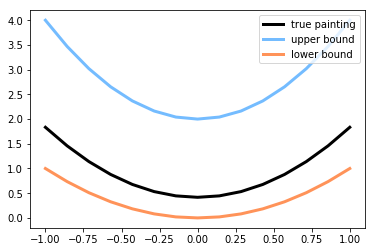

In [1]:
"""
Adapted from Morvin Zhou: https://morvanzhou.github.io/tutorials/
Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
tensorflow: 1.1.0
matplotlib
numpy
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas


# painting from the famous artist (real target)
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])
a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
paintings = a * np.power(PAINT_POINTS, 2) + (a-1)

viz_aid_upper = np.power(PAINT_POINTS[0], 2) + 1
viz_aid_lower = np.power(PAINT_POINTS[0], 2) + 0
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], paintings[0], c='#000000', lw=3, label='true painting',)
plt.plot(PAINT_POINTS[0], 2 * viz_aid_upper, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * viz_aid_lower, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()



In [2]:
G_in = tf.placeholder(tf.float32, [None, N_IDEAS])          # random ideas (could from normal distribution)
real_art = tf.placeholder(tf.float32, [None, ART_COMPONENTS], name='real_in')   # receive art work from the famous artist    

def generator():
    # variable scope is to distinguish the variables that belong to the generator from those that belong to the discriminator
    with tf.variable_scope('Generator', reuse=tf.AUTO_REUSE):
        G_l1 = tf.layers.dense(G_in, 128, tf.nn.relu)
        G_out = tf.layers.dense(G_l1, ART_COMPONENTS)               # making a painting from these random ideas
        return G_out
        
def discriminator():
    G_out = generator()
    with tf.variable_scope('Discriminator', reuse=tf.AUTO_REUSE):
        D_l0 = tf.layers.dense(real_art, 128, tf.nn.relu, name='l')
        prob_artist0 = tf.layers.dense(D_l0, 1, tf.nn.sigmoid, name='out')              # probability that the art work is made by artist
        # reuse layers for generator
        D_l1 = tf.layers.dense(G_out, 128, tf.nn.relu, name='l', reuse=True)            # receive art work from a newbie like G
        prob_artist1 = tf.layers.dense(D_l1, 1, tf.nn.sigmoid, name='out', reuse=True)  # probability that the art work is made by artist
        return G_out, prob_artist0, prob_artist1

def train_model():
    G_out, prob_artist0, prob_artist1 = discriminator()
    D_loss = -tf.reduce_mean(tf.log(prob_artist0) + tf.log(1-prob_artist1))
    G_loss = tf.reduce_mean(tf.log(1-prob_artist1))

    train_D = tf.train.AdamOptimizer(LR_D).minimize(
        D_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator'))
    train_G = tf.train.AdamOptimizer(LR_G).minimize(
        G_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator'))
    return G_out, prob_artist0, prob_artist1, D_loss, G_loss, train_D, train_G


In [9]:
# These are all the variables we need from the model training
G_out, prob_artist0, prob_artist1, D_loss, G_loss, train_D, train_G = train_model()

ValueError: Variable Discriminator/l/kernel/Adam/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-2-3022e55d3105>", line 26, in train_model
    D_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator'))
  File "<ipython-input-8-27cbe9e00139>", line 3, in <module>
    G_out, prob_artist0, prob_artist1, D_loss, G_loss, train_D, train_G = train_model()
  File "/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


Note that we use the word "converge" in learning to mean that the model learns to the lowest loss rate possible. With GANs, notice that both the generator and discriminator can achieve this rate, and then lose it, and return towards it as they continue in their "game" of trying to outperform each other.

In [4]:
def run_sess():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    plt.ion()   # something about continuous plotting
    for step in range(5000):
        artist_paintings = paintings           # real painting from artist
        G_ideas = np.random.randn(BATCH_SIZE, N_IDEAS)
        G_paintings, pa0, Dl = sess.run([G_out, prob_artist0, D_loss, train_D, train_G],    # train and get results
                                        {G_in: G_ideas, real_art: artist_paintings})[:3]

        if step % 50 == 0:  # plotting
            plt.cla()
            plt.plot(PAINT_POINTS[0], 2 * viz_aid_upper, c='#74BCFF', lw=3, label='upper bound')
            plt.plot(PAINT_POINTS[0], 1 * viz_aid_lower, c='#FF9359', lw=3, label='lower bound')
            plt.plot(PAINT_POINTS[0], G_paintings[0], c='#4AD631', lw=3, label='Generated painting',)
            plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % pa0.mean(), fontdict={'size': 15})
            plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -Dl, fontdict={'size': 15})
            plt.ylim((0, 6)); plt.legend(loc='upper right', fontsize=12); plt.draw(); plt.pause(0.01)

    plt.ioff()
    plt.show()

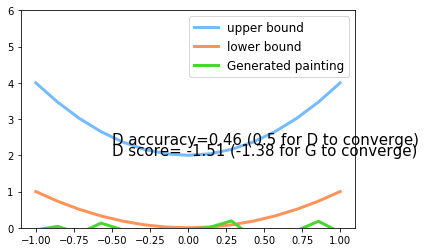

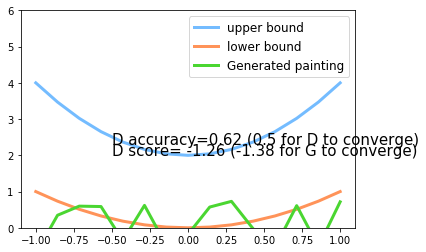

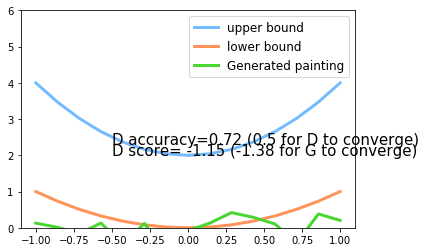

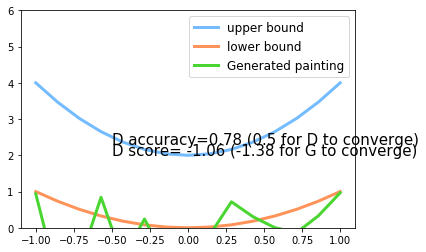

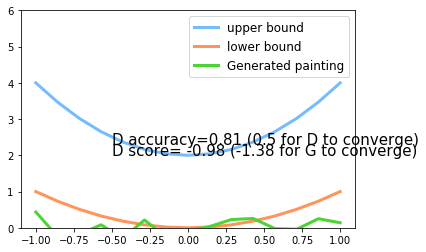

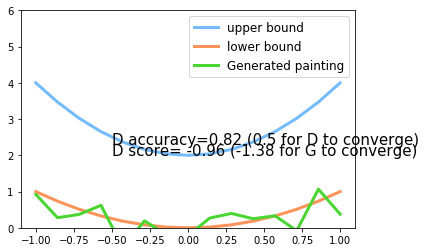

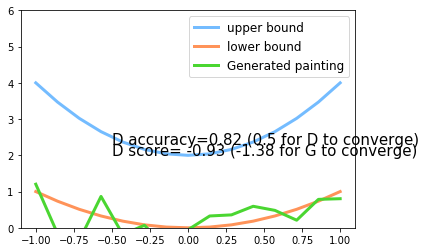

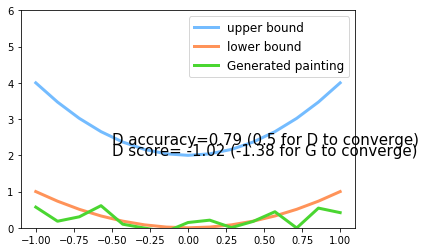

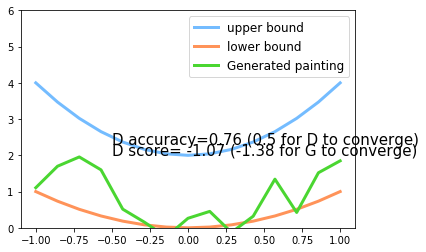

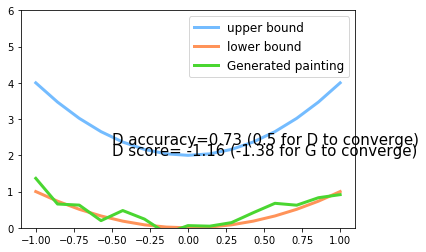

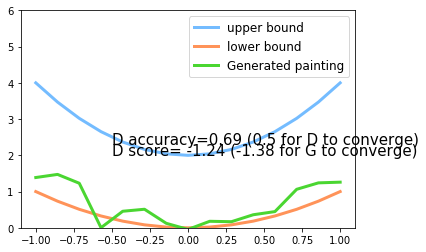

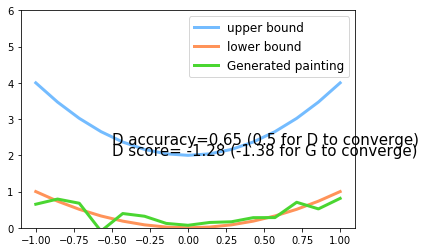

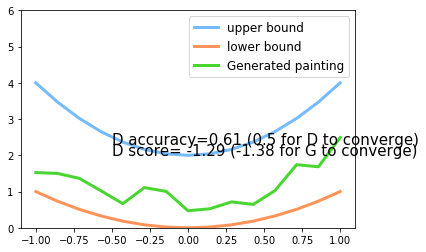

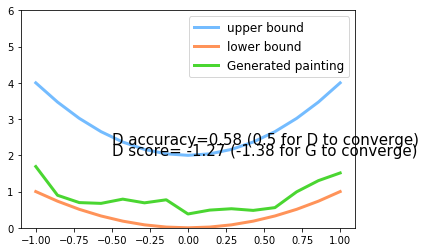

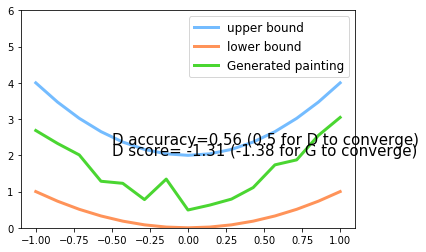

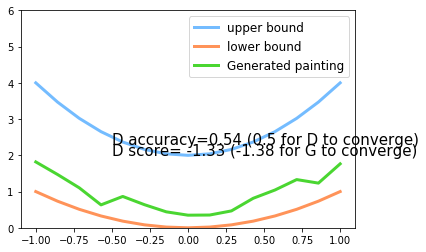

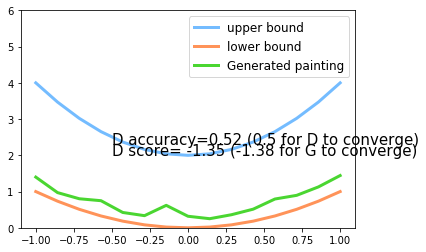

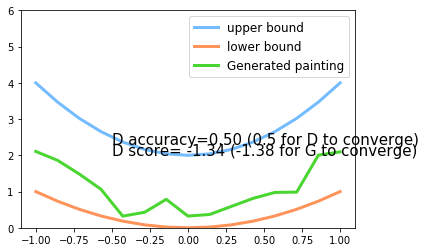

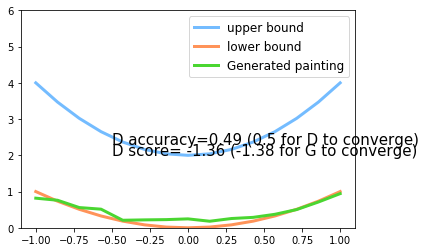

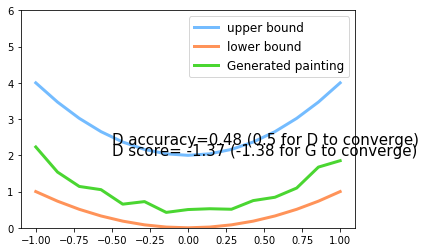

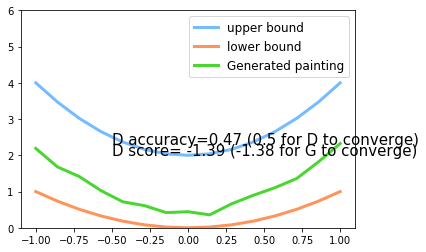

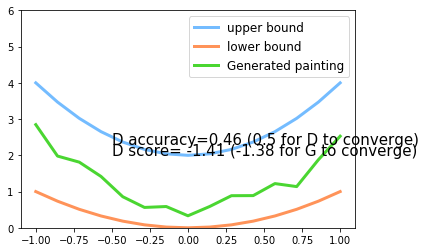

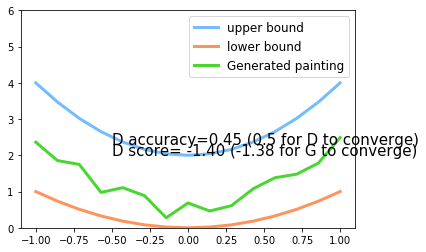

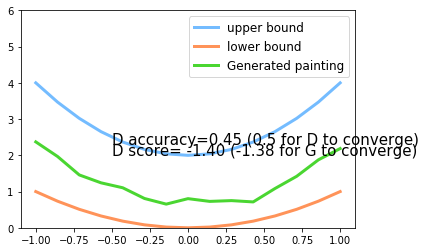

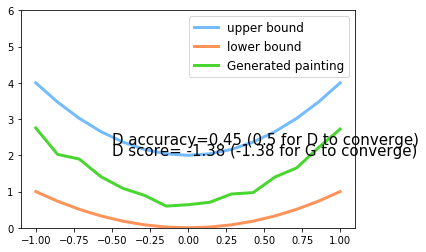

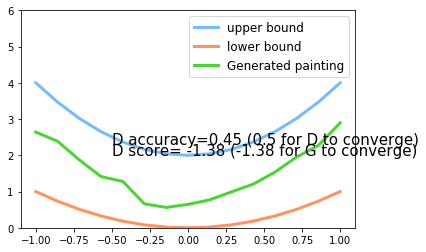

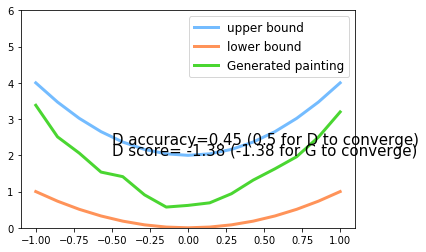

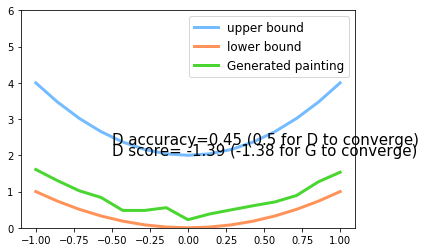

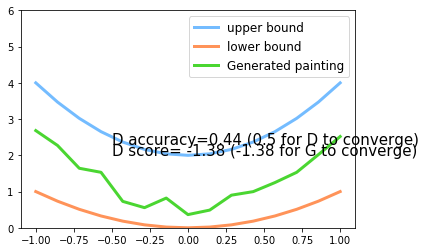

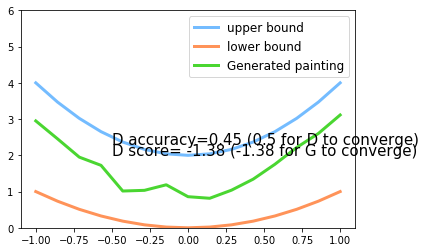

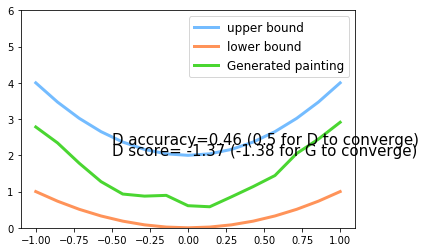

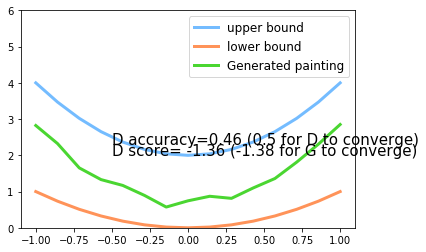

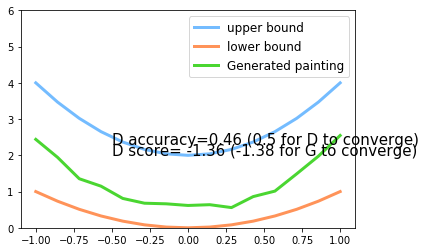

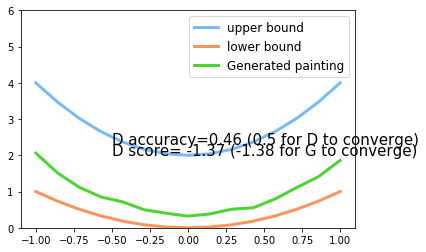

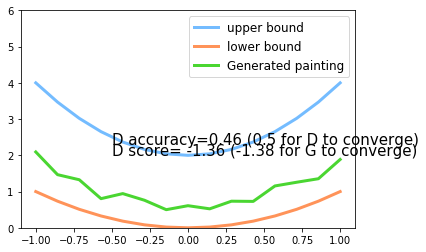

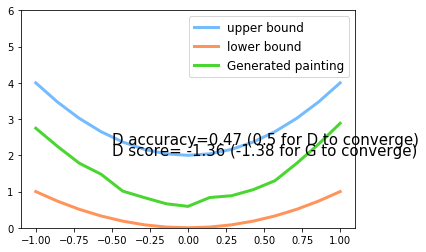

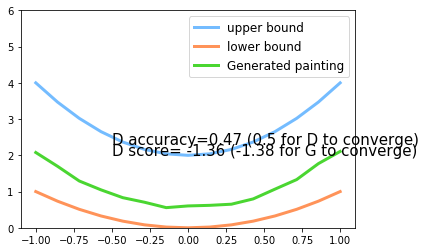

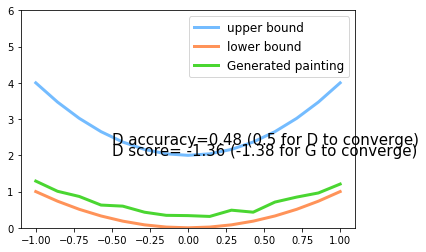

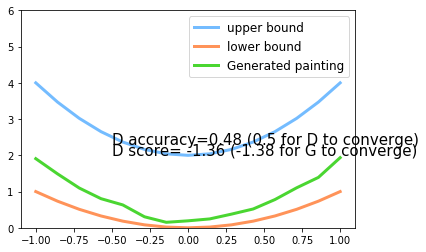

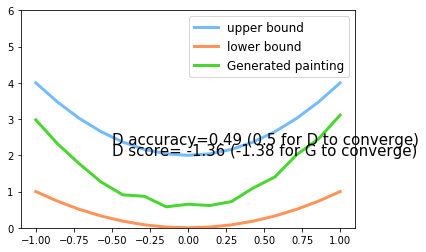

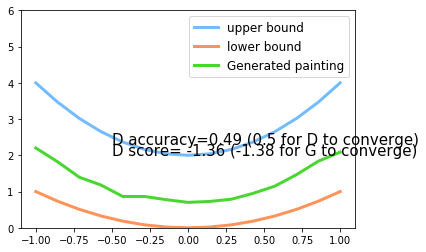

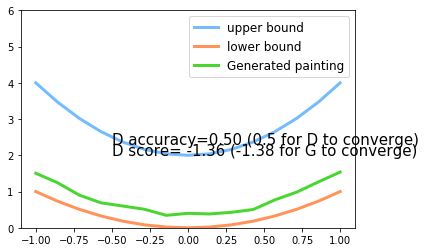

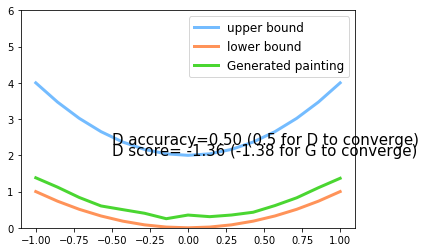

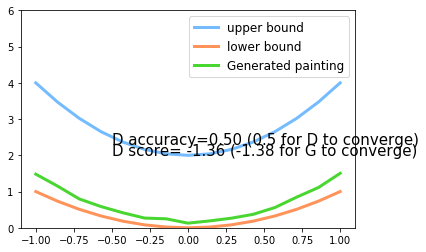

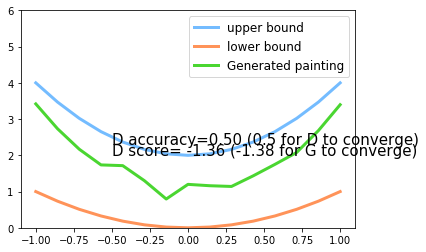

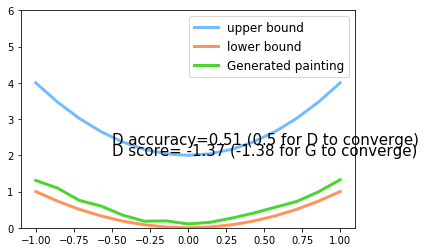

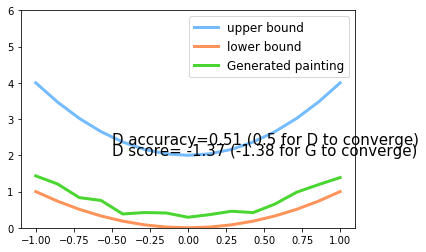

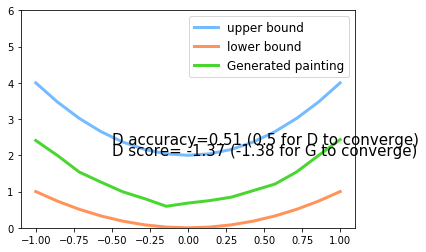

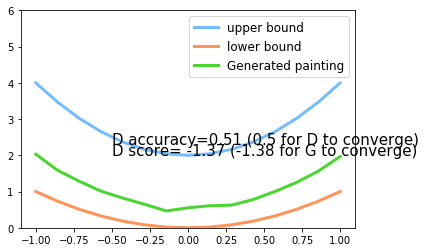

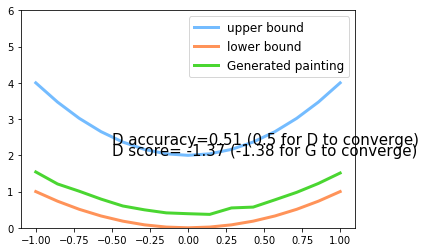

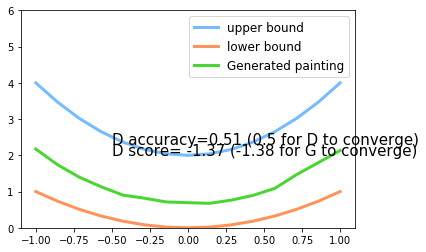

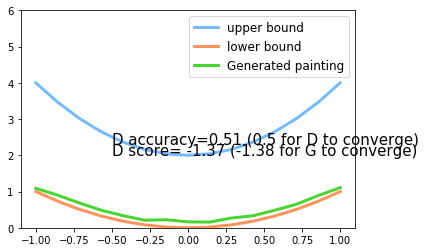

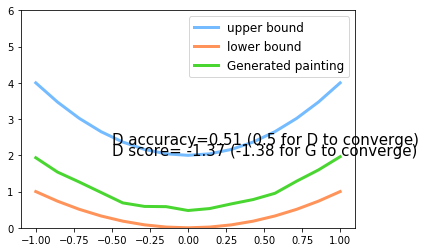

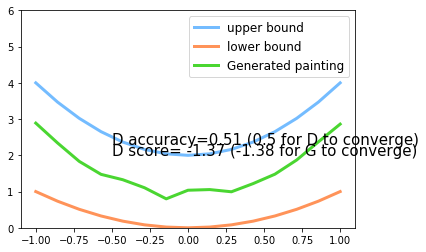

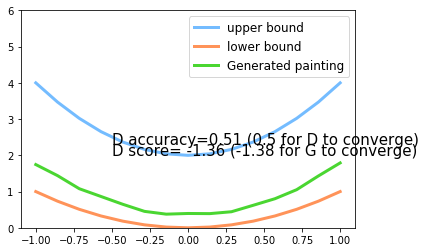

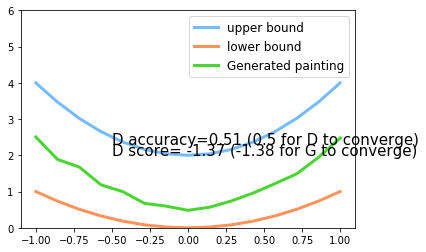

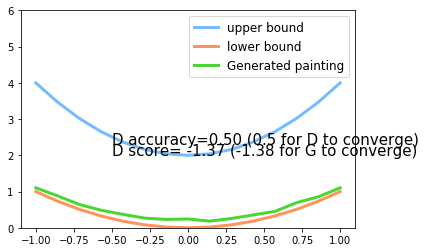

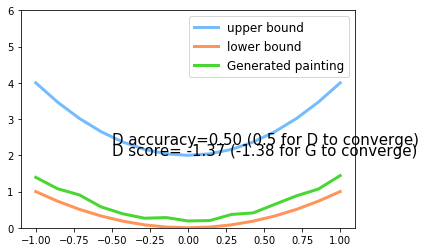

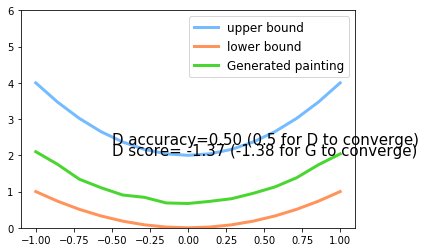

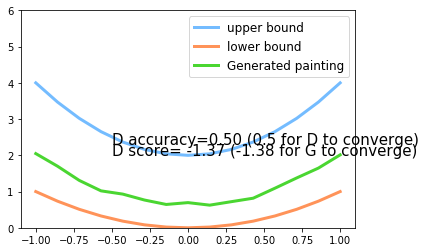

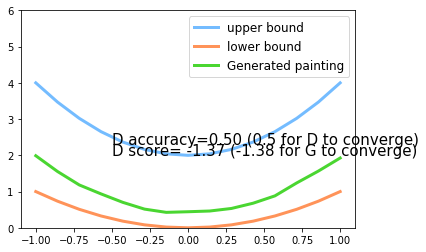

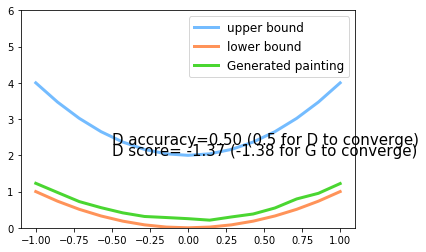

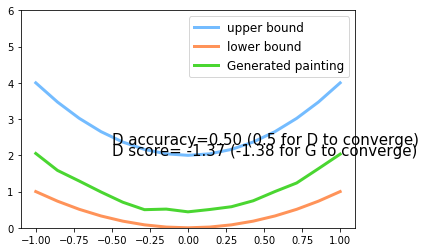

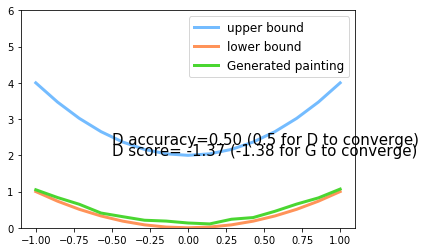

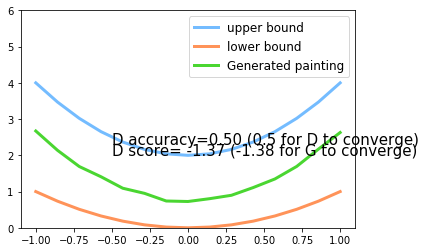

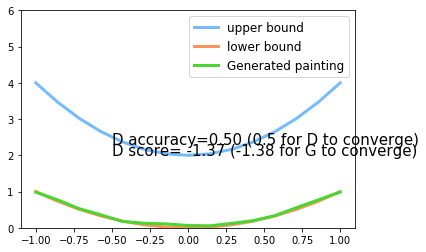

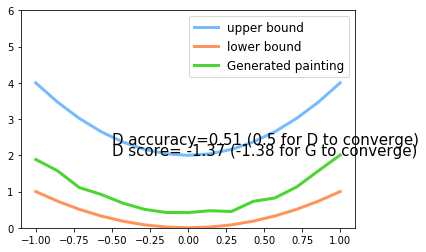

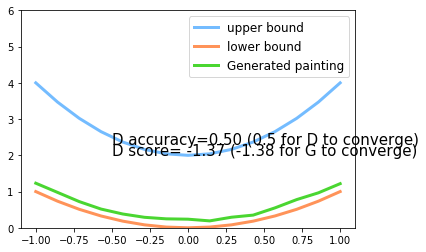

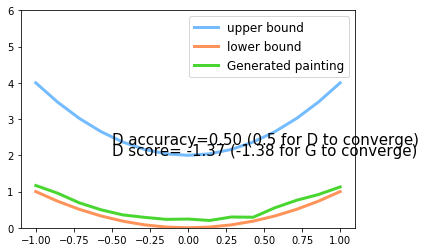

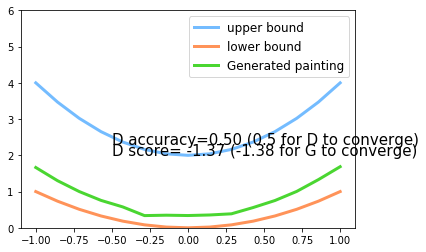

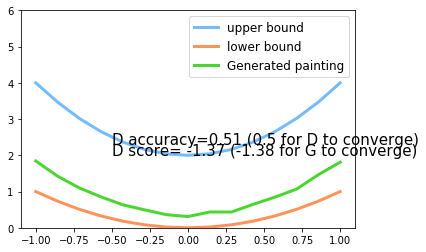

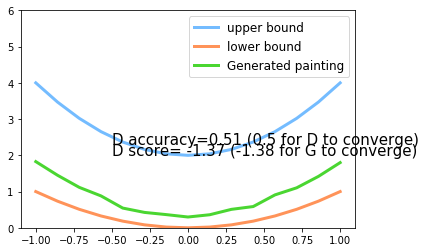

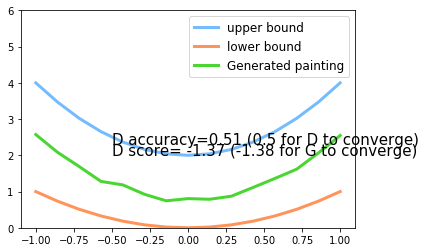

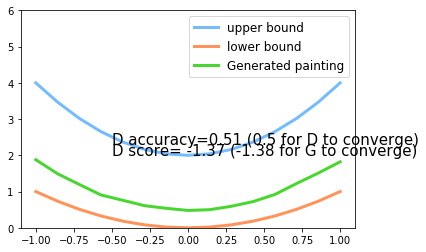

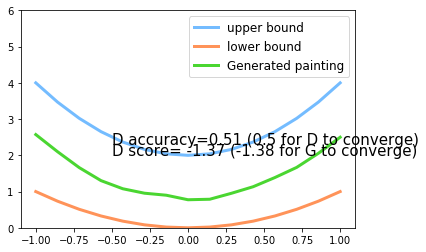

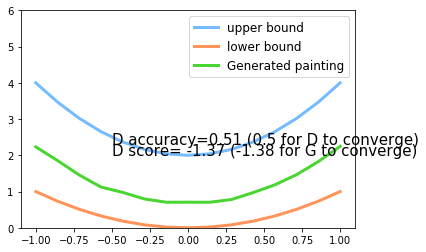

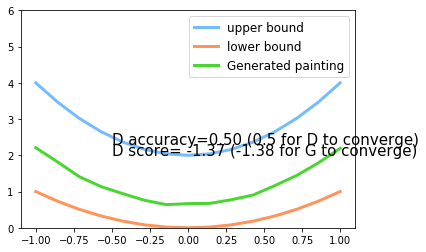

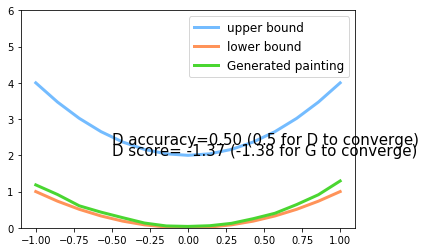

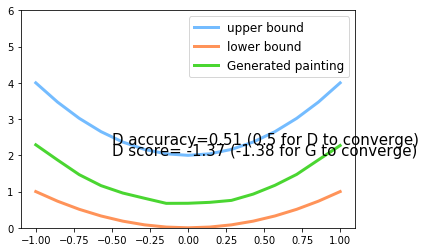

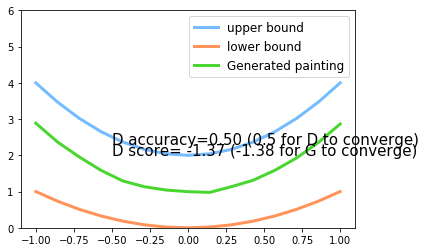

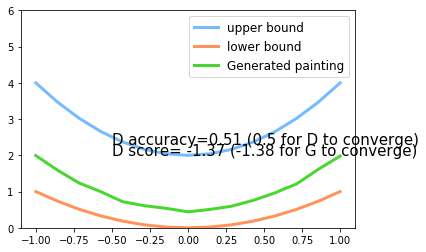

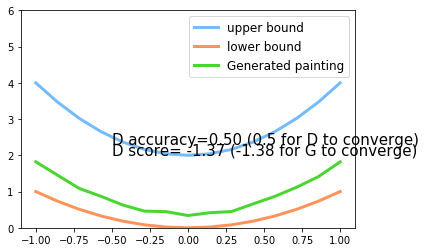

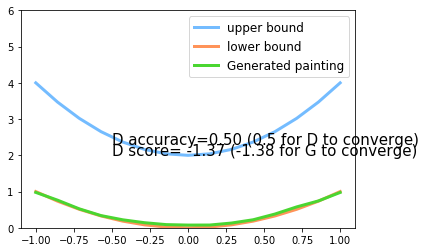

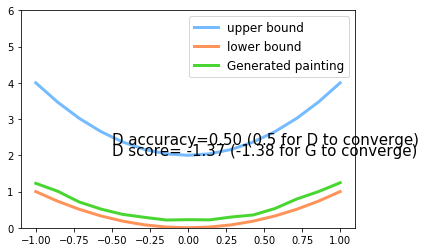

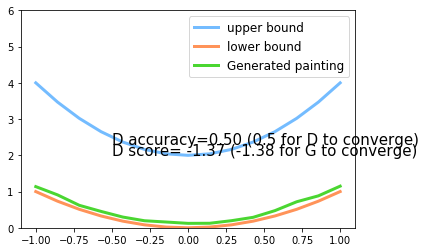

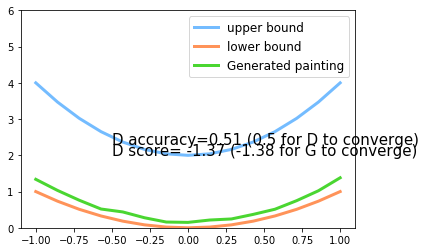

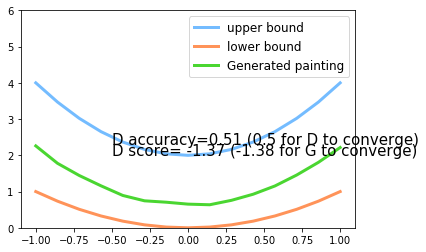

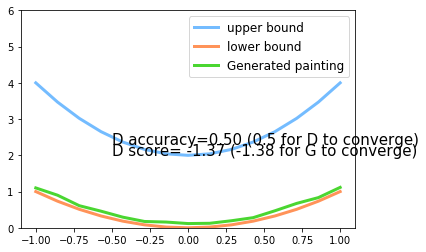

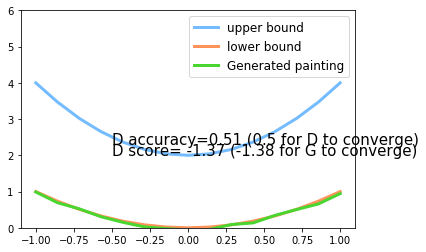

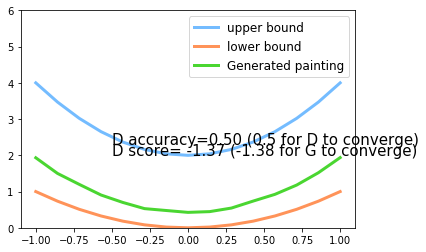

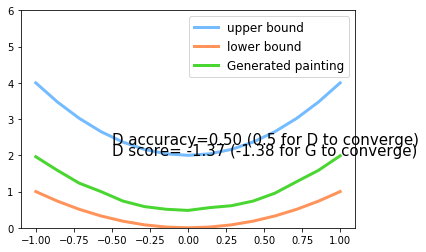

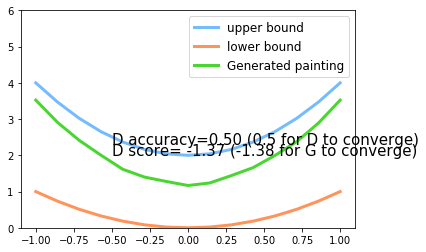

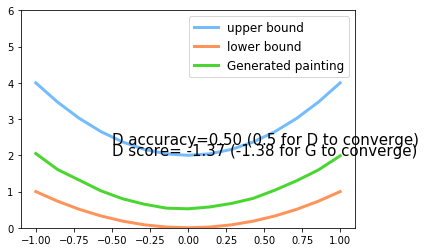

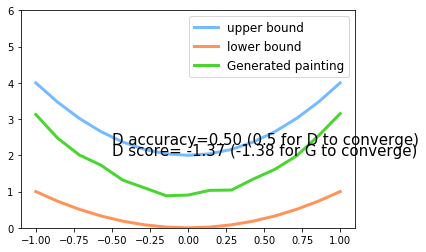

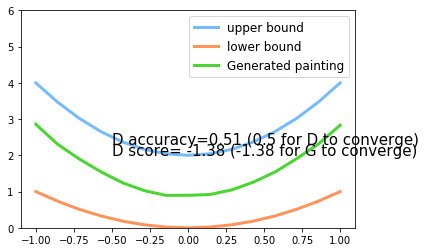

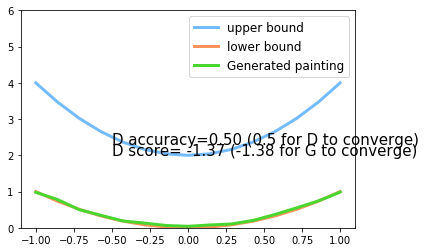

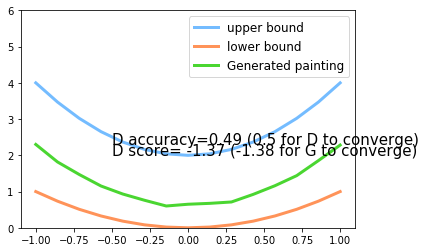

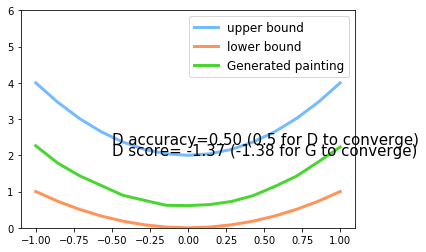

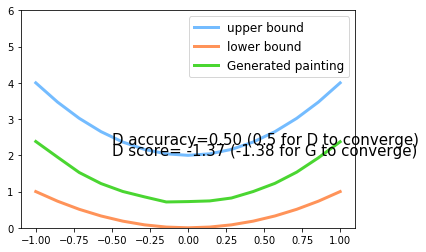

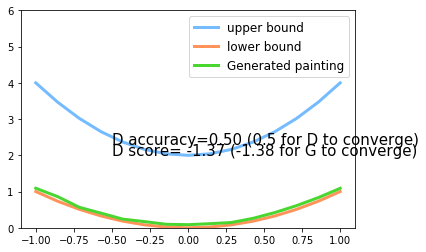

In [5]:
run_sess()

Now let's see how it handles a more complex space

In [6]:
tf.reset_default_graph()

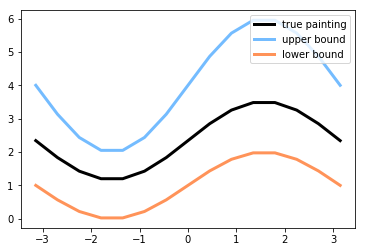

In [7]:
# painting from the famous artist (real target)
PAINT_POINTS = np.vstack([np.linspace(-np.pi, np.pi, ART_COMPONENTS) for _ in range(BATCH_SIZE)])
a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
paintings = a * (np.sin(PAINT_POINTS)+1) + (a)

viz_aid_upper = np.sin(PAINT_POINTS[0]) + 2
viz_aid_lower = np.sin(PAINT_POINTS[0]) + 1

# show our beautiful painting range - NOTE WE ARE EXPANDING THE VISUAL SPACE HERE AS A VISUAL AID
plt.plot(PAINT_POINTS[0], paintings[0], c='#000000', lw=3, label='true painting',)
plt.plot(PAINT_POINTS[0], 2 * viz_aid_upper, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * viz_aid_lower, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

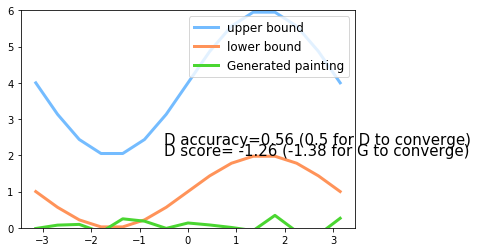

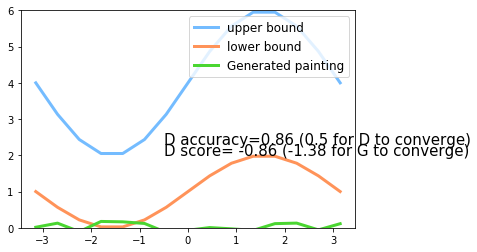

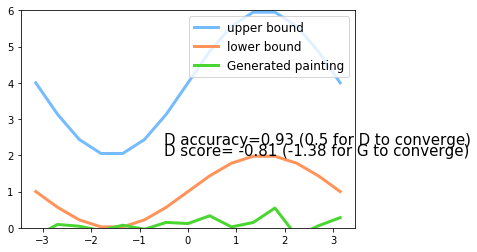

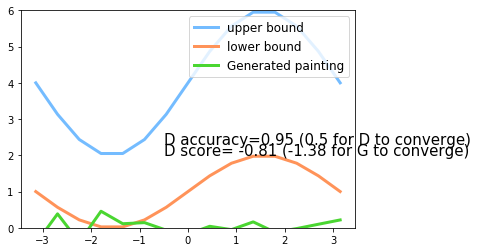

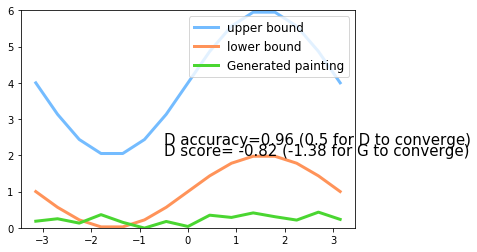

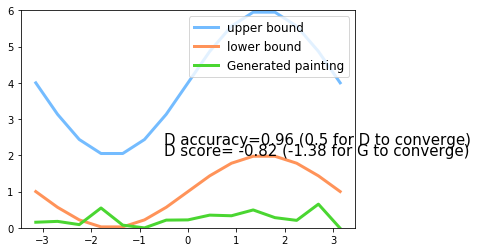

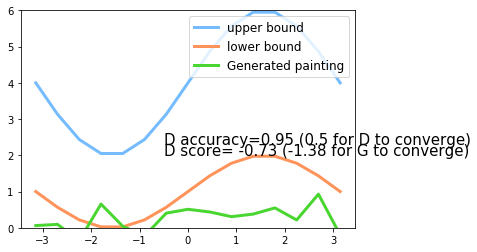

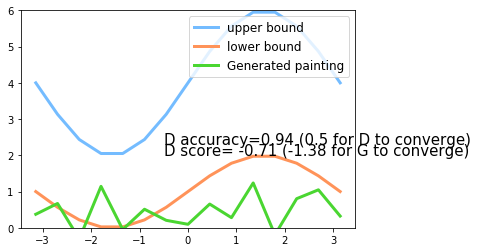

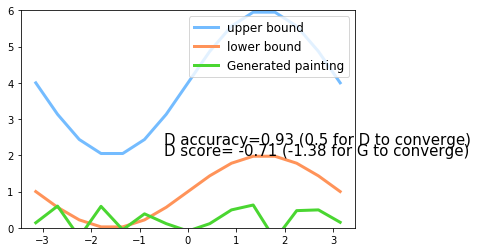

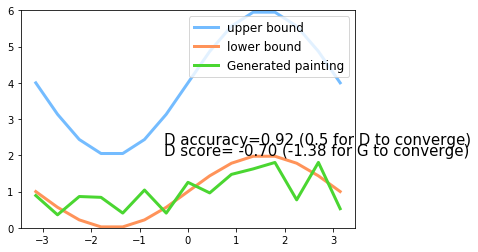

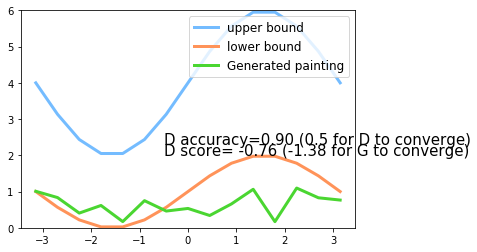

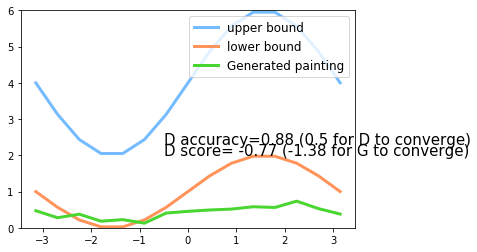

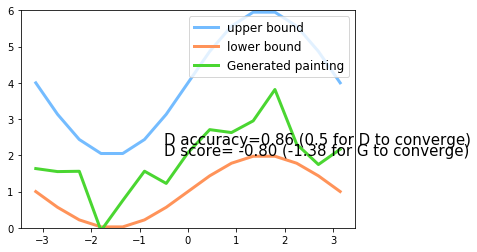

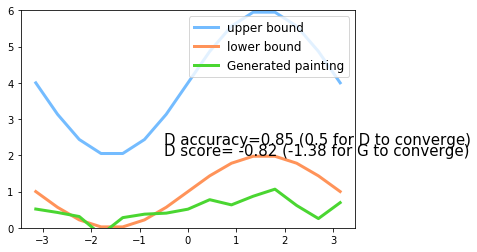

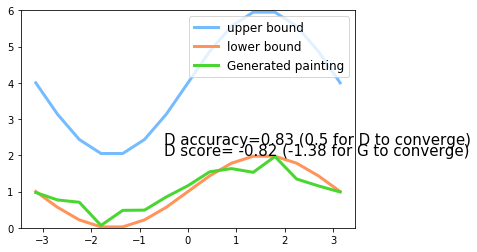

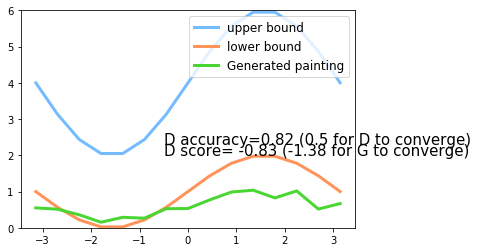

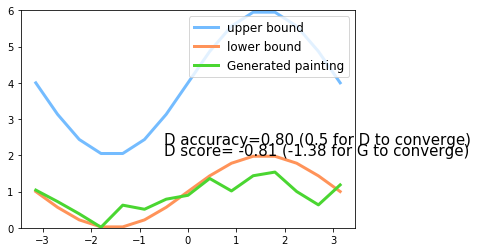

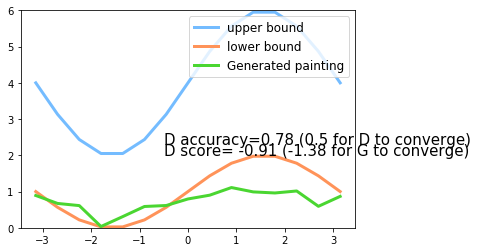

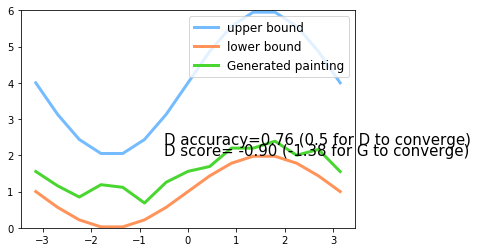

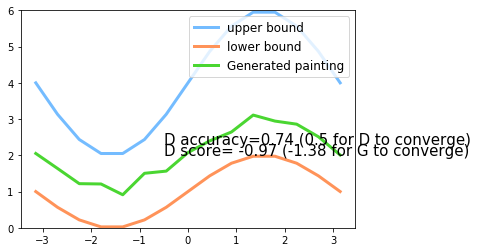

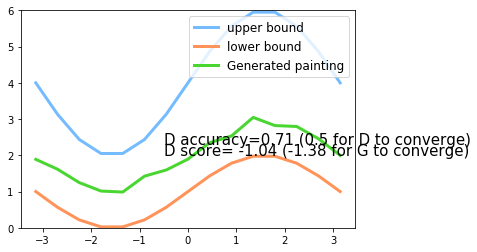

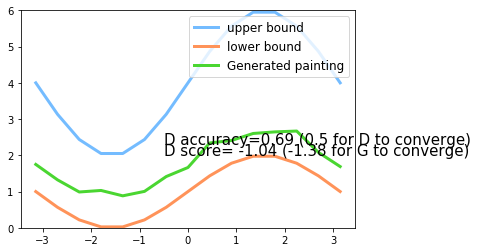

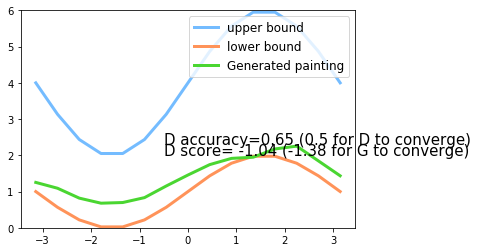

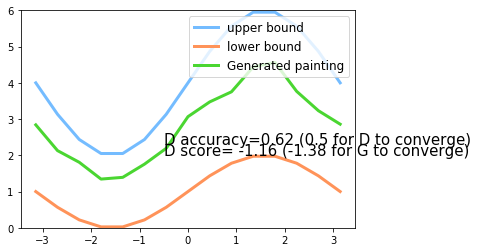

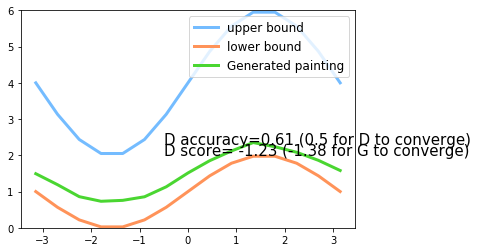

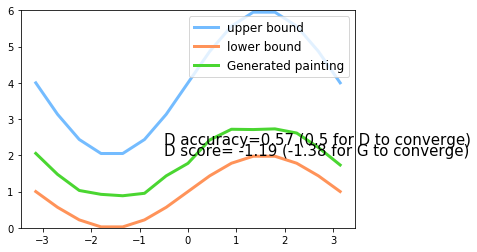

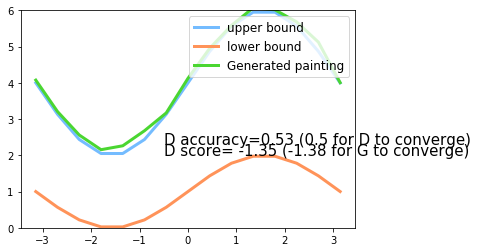

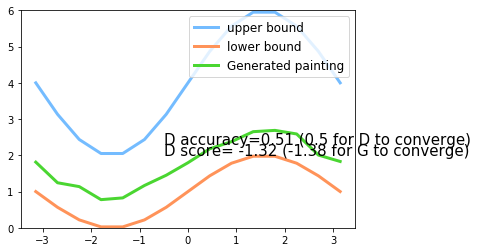

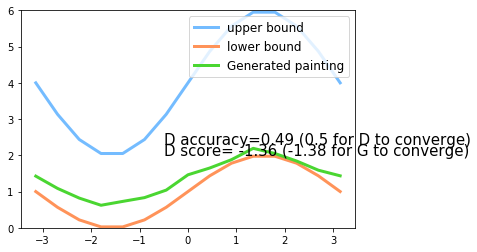

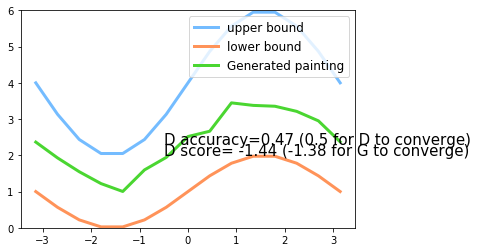

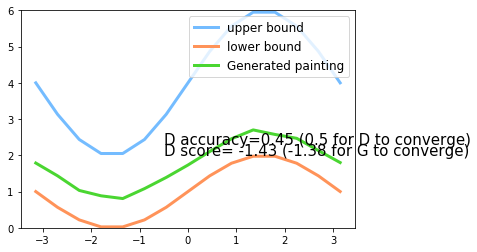

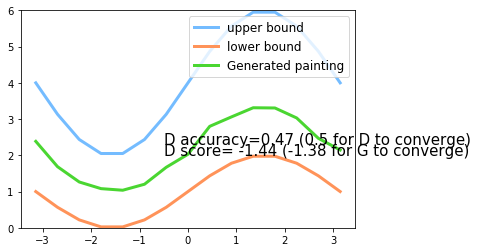

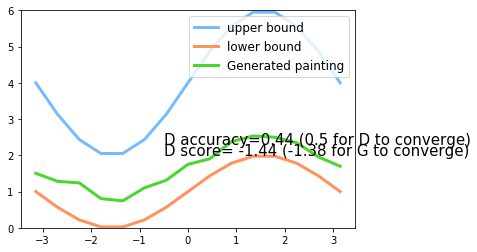

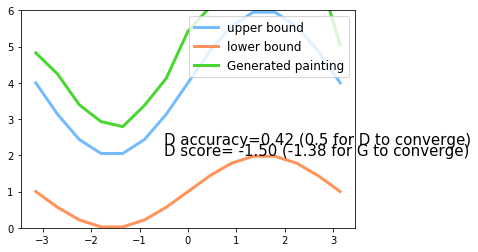

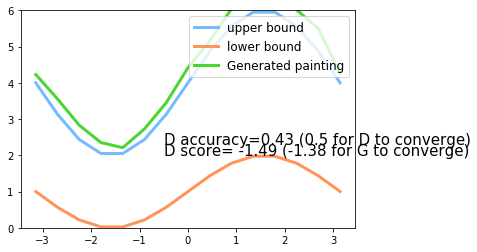

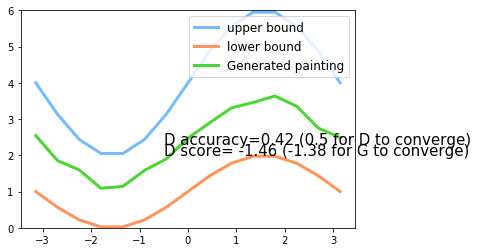

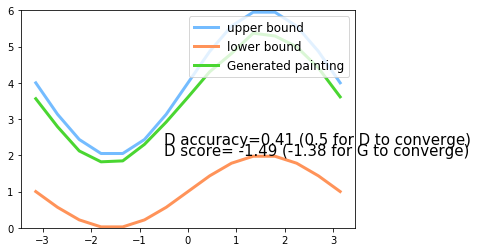

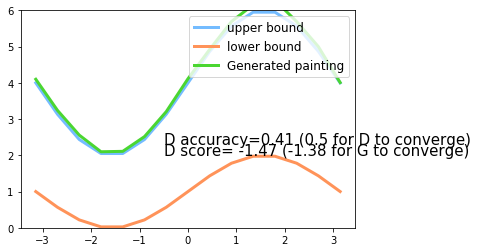

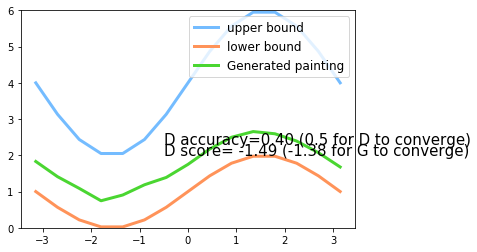

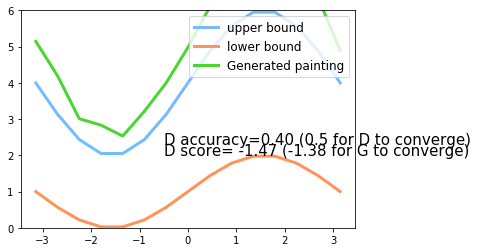

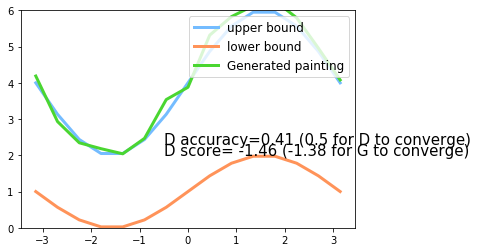

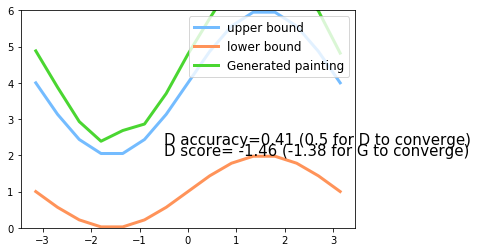

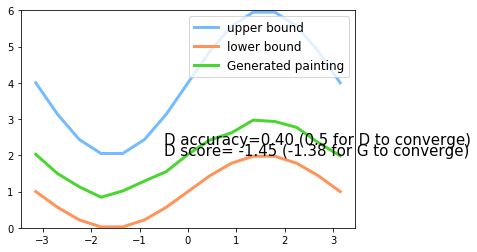

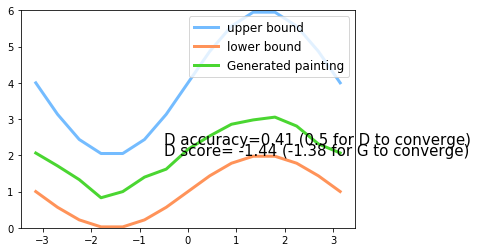

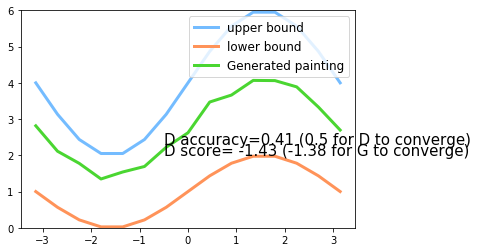

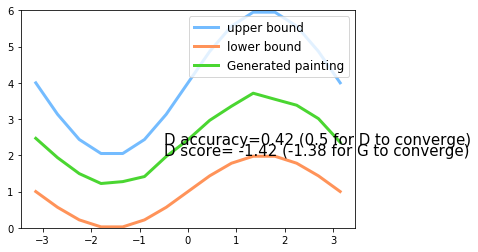

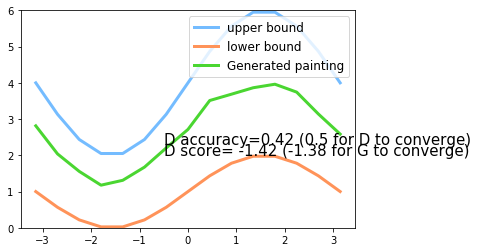

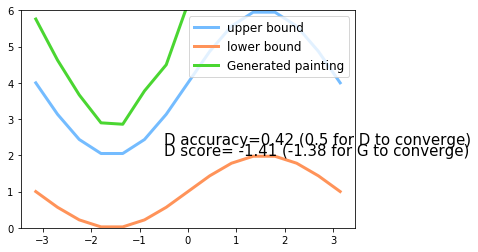

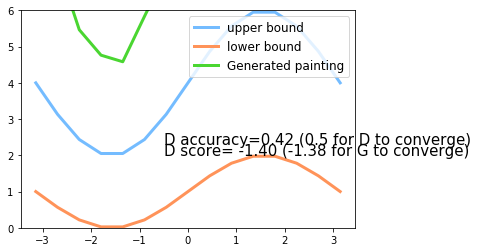

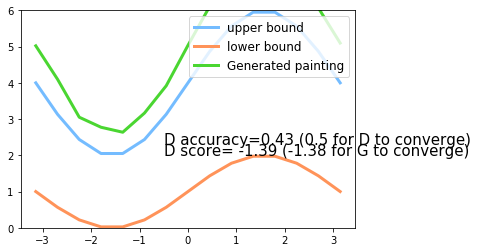

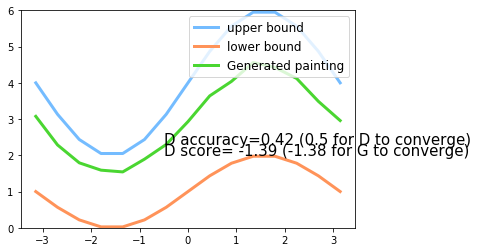

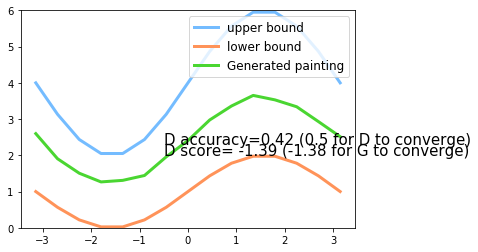

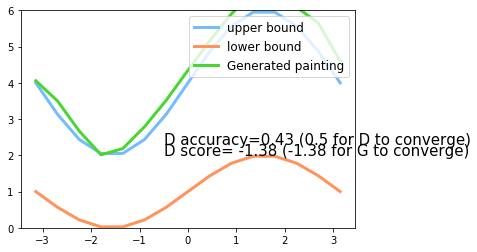

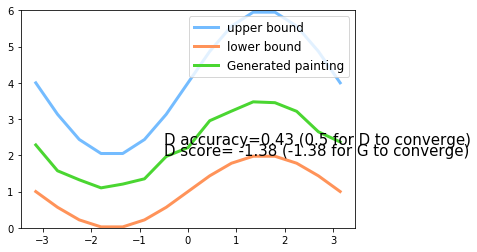

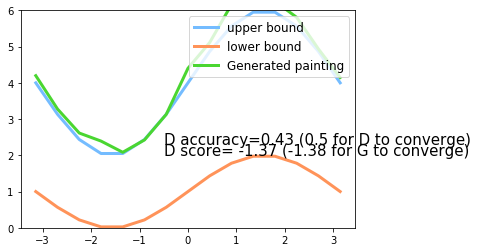

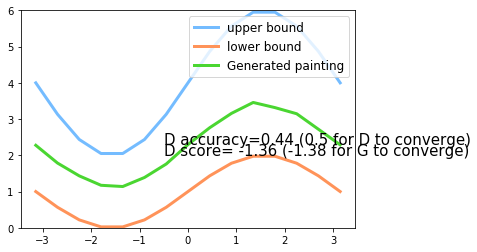

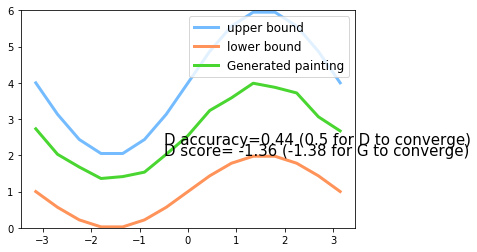

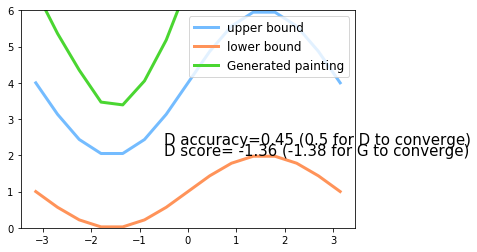

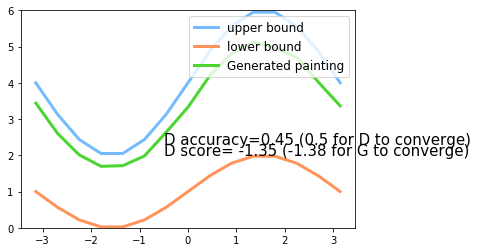

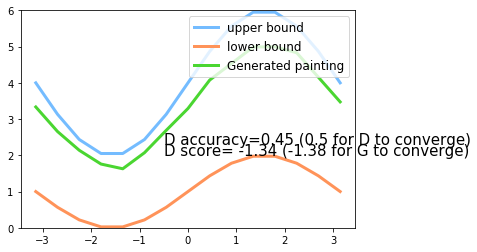

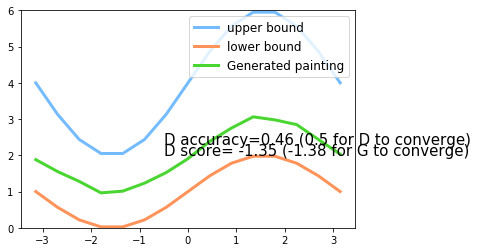

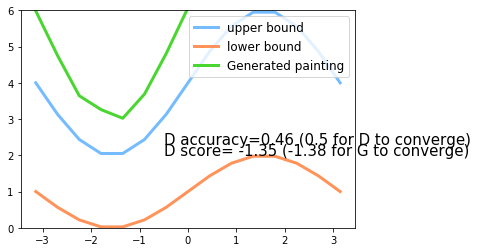

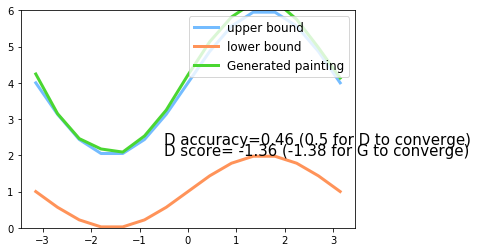

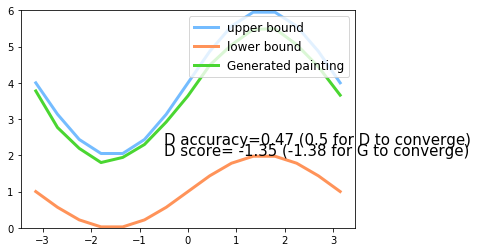

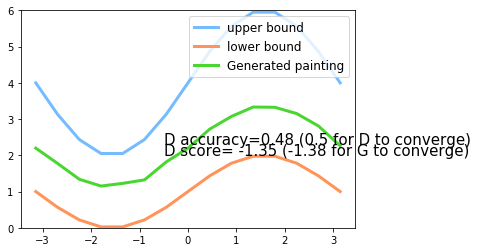

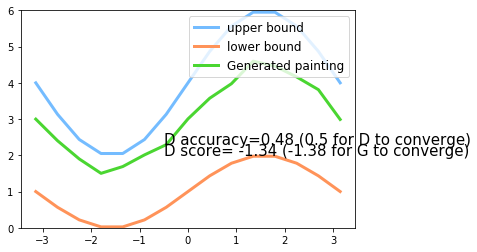

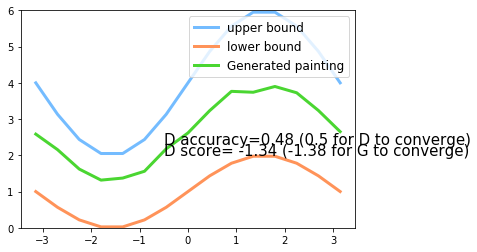

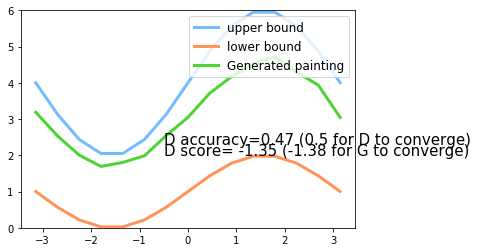

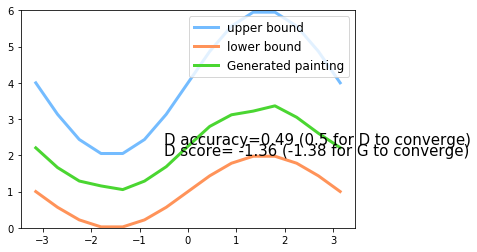

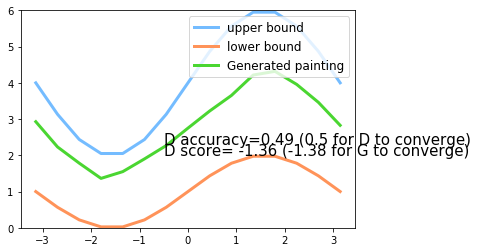

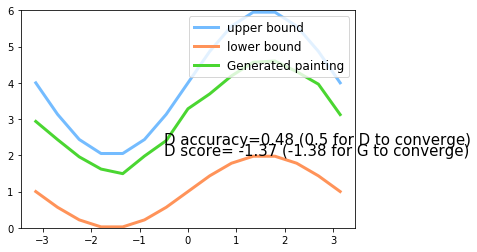

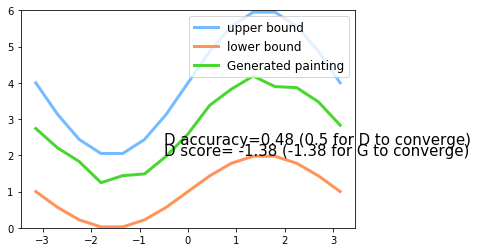

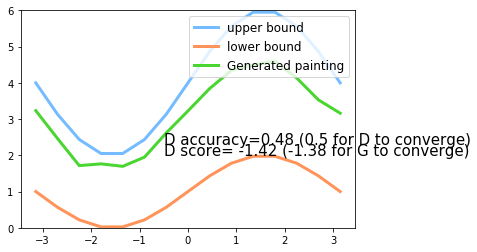

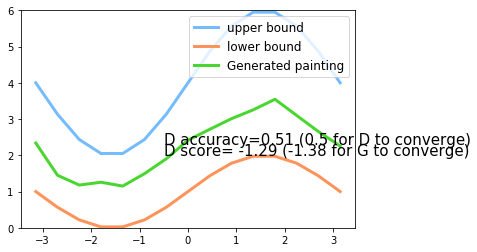

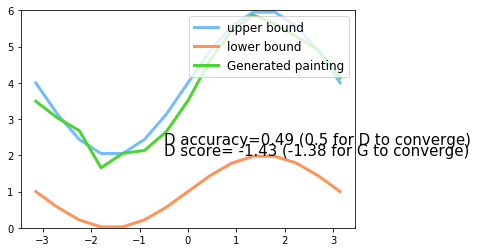

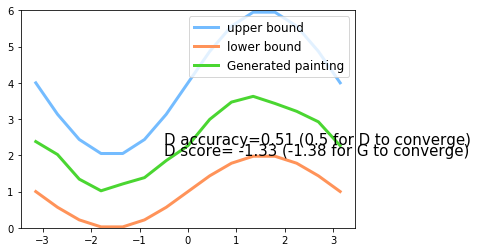

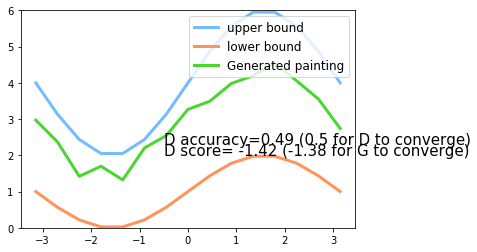

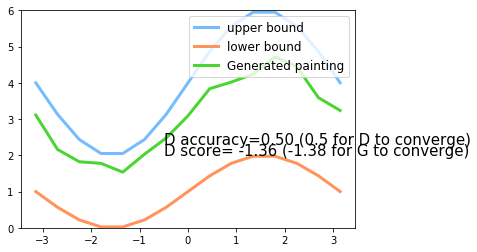

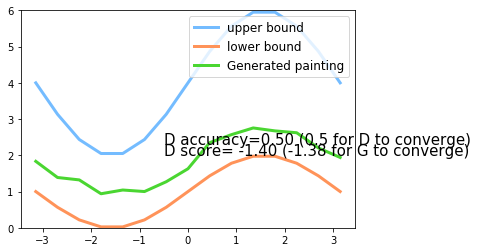

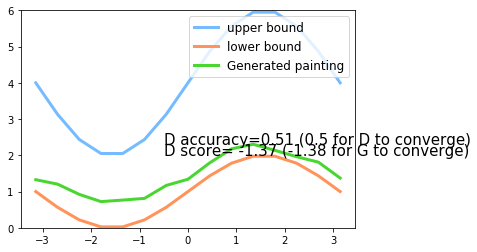

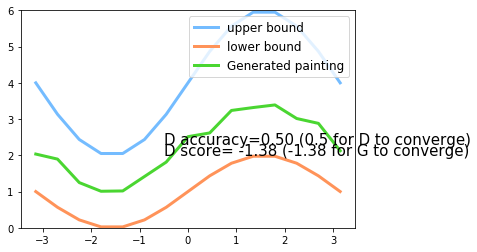

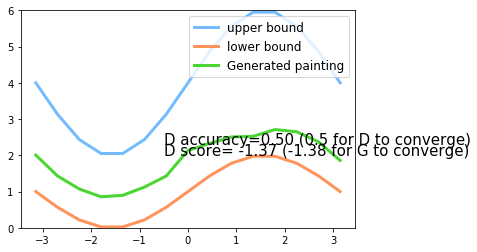

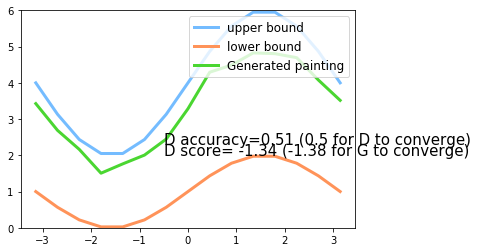

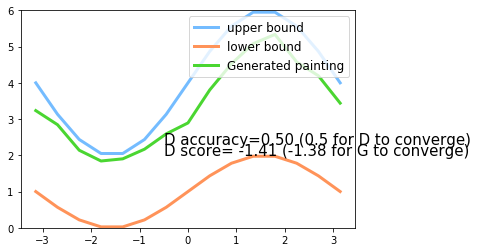

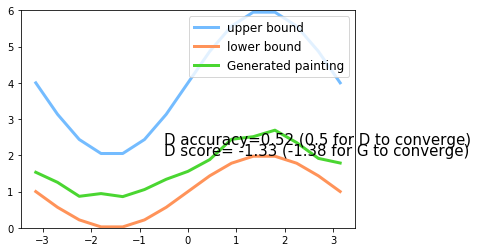

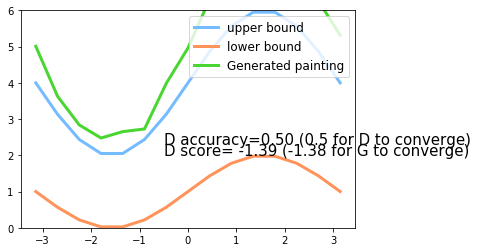

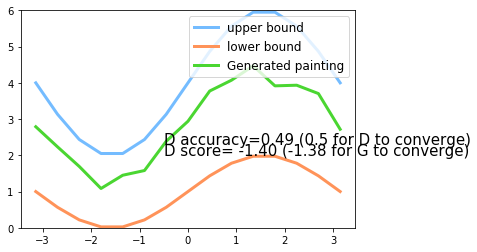

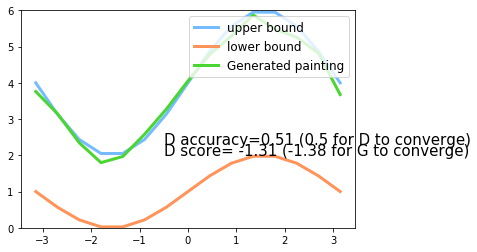

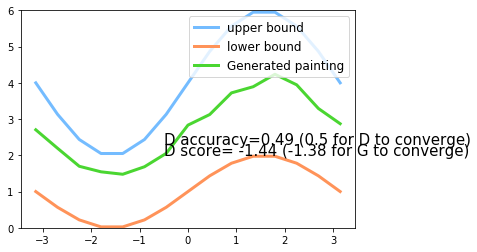

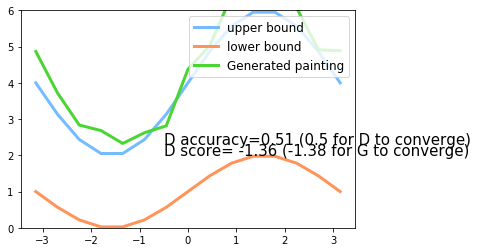

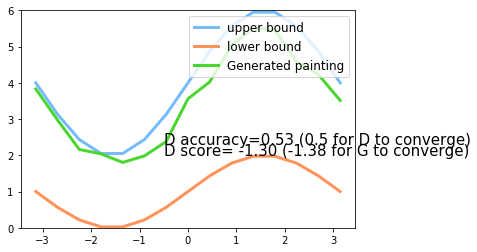

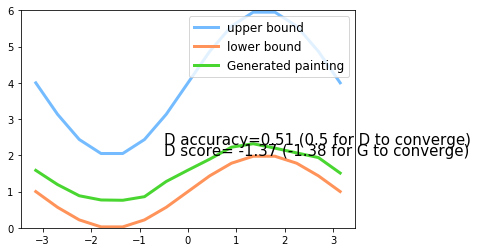

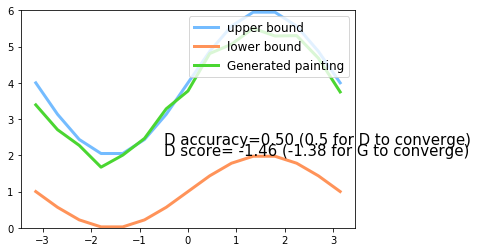

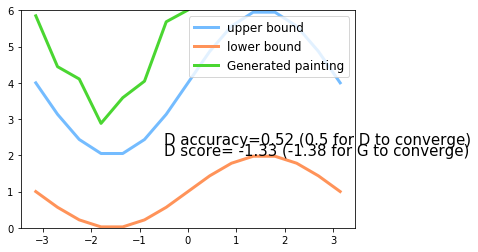

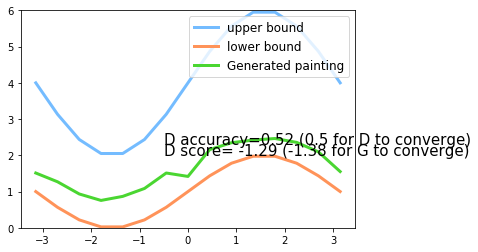

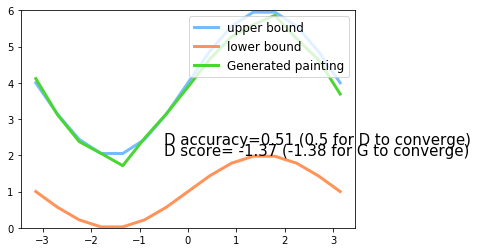

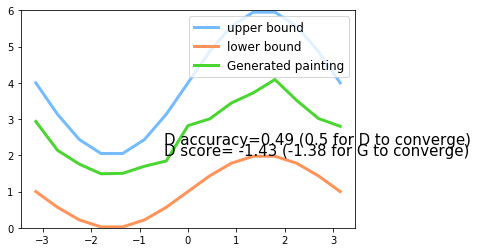

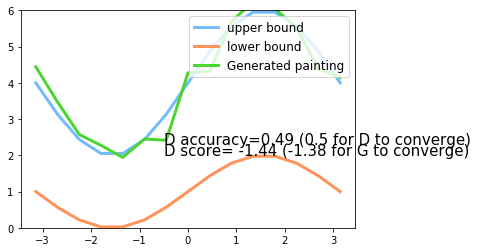

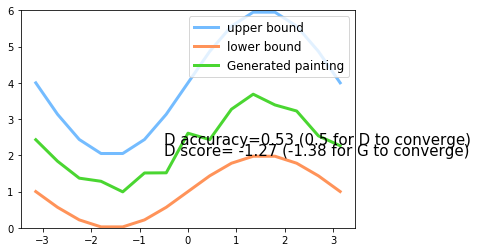

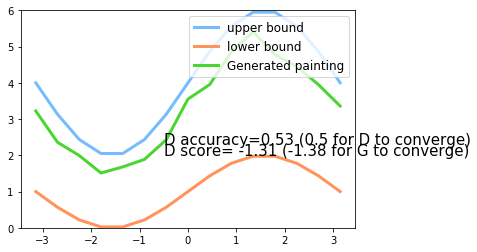

In [8]:
G_in = tf.placeholder(tf.float32, [None, N_IDEAS])          # random ideas (could from normal distribution)
real_art = tf.placeholder(tf.float32, [None, ART_COMPONENTS], name='real_in')   # receive art work from the famous artist    
G_out, prob_artist0, prob_artist1, D_loss, G_loss, train_D, train_G = train_model()
run_sess()

Try designing even more sophisticated figures. What is the limitation of complexity this model is capable of fitting?

Other options would be to try different activation functions from either or both the sigmoid and relu functions in this model. Or, try adding another layer once you've reached the limit of complexity the model is able to learn well.